# Transmissibility

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False

First, setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('..'))
from utils import setup_spreadr
setup_spreadr('spreadr_exp_1')

Then import all we need for the analysis

In [3]:
from itertools import product

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Patch
import numpy as np
from pandas import DataFrame
import seaborn as sb

from gists.models import Sentence, Tree

from utils import grouper, memoized, mpl_palette

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

  warnings.warn(self.msg_depr % (key, alt_key))



Equip our models with useful tools

In [4]:
from utils import equip_spreadr_models as utils_equip
utils_equip()

from linguistics import equip_spreadr_models as linguistics_equip
linguistics_equip()

## 2 Transmissibility of sentences

First generate our data

In [5]:
trees = Tree.objects.experiment.all()
data = []
order = []
for tree in trees:
    root = tree.root
    root_length = len(root.content_words)
    order.append({'tree id': tree.id,
                  'root length': root_length})
    for sentence in tree.sentences.kept.all():
        length = len(sentence.content_words)
        for child in sentence.children.kept.all():
            data.append({'tree id': tree.id,
                         'sentence id': sentence.id,
                         'length': length,
                         'root length': root_length,
                         'depth': sentence.depth,
                         'branch id': child.head.id,
                         'transmit success': sentence.ordered_content_distance(child) == 0})
data = DataFrame(data)
data_m15 = data[data['root length'] < 15]
root_order = DataFrame(order).sort_values(['root length', 'tree id'])

### 2.1 Quick look at interactions

First with all the data

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

  warnings.warn(self.msg_depr % (key, alt_key))



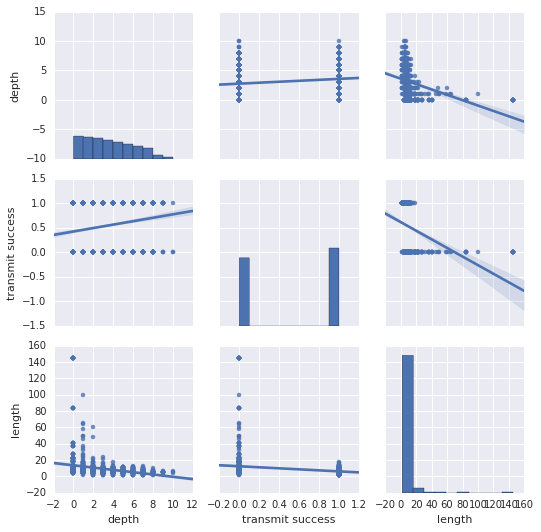

In [6]:
g = sb.pairplot(data=data,
                vars=['depth', 'transmit success', 'length'], kind='reg')

Then restricting to trees where the root sentence is less than 15 content words

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

  warnings.warn(self.msg_depr % (key, alt_key))



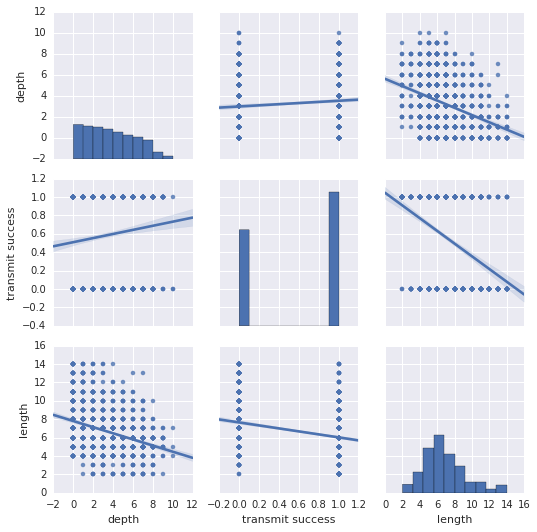

In [7]:
g = sb.pairplot(data=data_m15,
                vars=['depth', 'transmit success', 'length'], kind='reg')

### 2.2 Transmissibility ~ depth, global

Plotting function to have the evolution of average transmissibility

In [8]:
def plot_transmissibility(data, **kwargs):
    color = kwargs.get('color', sb.color_palette()[0])
    depth_success = data.groupby('depth')['transmit success']

    # Compute transmissibilities per depth
    heights = depth_success.mean()
    cis = depth_success.std() * 1.96 / np.sqrt(depth_success.size() - 1)

    # Plot
    plt.plot(heights.index, heights, color=color)
    plt.fill_between(heights.index, heights - cis, heights + cis,
                    color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.ylim(0, 1)

Evolution of global transmissibility with all the data, computed as average per depth and as logistic regression against depth

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

  warnings.warn(self.msg_depr % (key, alt_key))



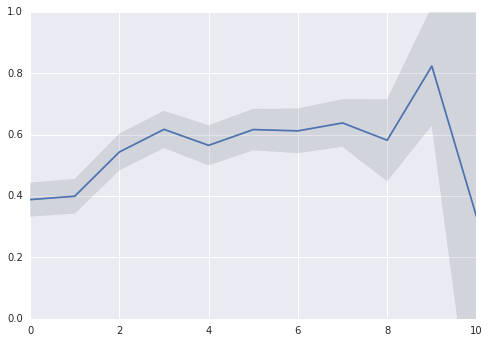

In [9]:
plot_transmissibility(data)

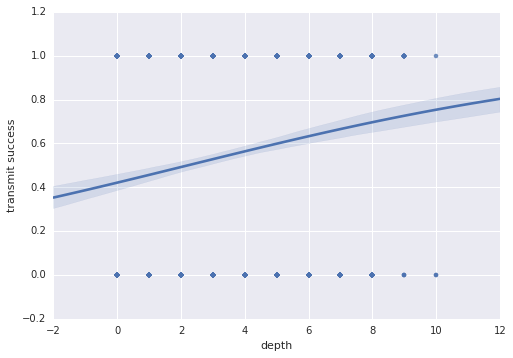

In [10]:
sb.regplot('depth', 'transmit success', data=data, logistic=True)

Then restricting to trees where the root sentence is less than 15 content words

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

  warnings.warn(self.msg_depr % (key, alt_key))



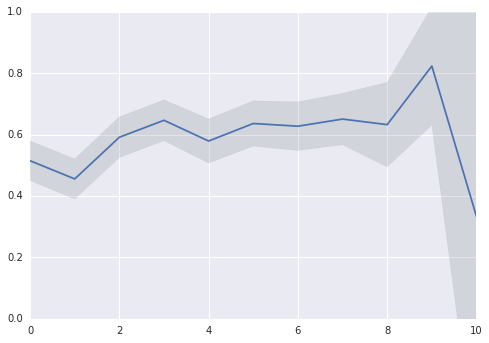

In [11]:
plot_transmissibility(data_m15)

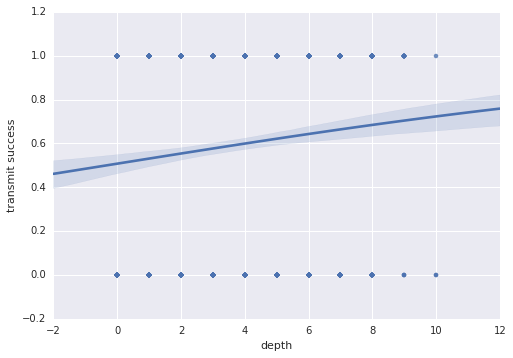

In [12]:
sb.regplot('depth', 'transmit success', data=data_m15, logistic=True)

### 2.3 Transmissibility ~ depth, per number of content words

**Note on logistic regressions**: since we slice up our data in many little categories, most of the time we run into [perfect separation](https://en.wikipedia.org/wiki/Separation_%28statistics%29) problems. For now, our way around this is to add regularization data to the categories: here for each combination of length and depth, we add a successful and an unsuccessful transmission, making sure the predicted variable of the regression always has both outcomes at least once, and hoping this doesn't skew the data too much.

In [17]:
def regularize_per_length(data):
    _data = []
    for length, depth, success in product(set(data.length.values),
                                          set(data.depth.values),
                                          [True, False]):
        _data.append({'tree id': -1,
                      'sentence id': -1,
                      'length': length,
                      'root_length': -1,
                      'depth': depth,
                      'branch id': -1,
                      'transmit success': success})
    return data.append(DataFrame(_data))

data23 = regularize_per_length(data)
data23_m15 = regularize_per_length(data_m15)

First with all the data, as average per depth and as logistic regression

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

  warnings.warn(self.msg_depr % (key, alt_key))



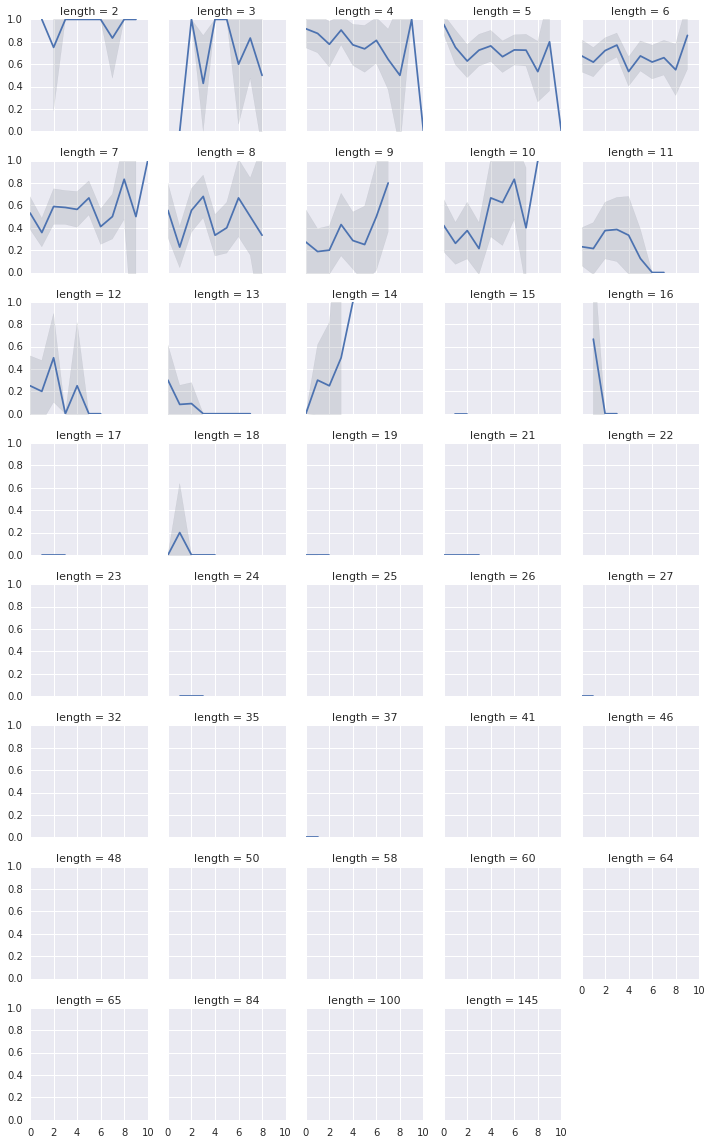

In [19]:
ordered_lengths = sorted(set(data.length.values))
g = sb.FacetGrid(data=data, col='length', col_wrap=5,
                 sharex=True, sharey=True, size=2,
                 col_order=ordered_lengths)
g.map_dataframe(plot_transmissibility)

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

  warnings.warn(self.msg_depr % (key, alt_key))



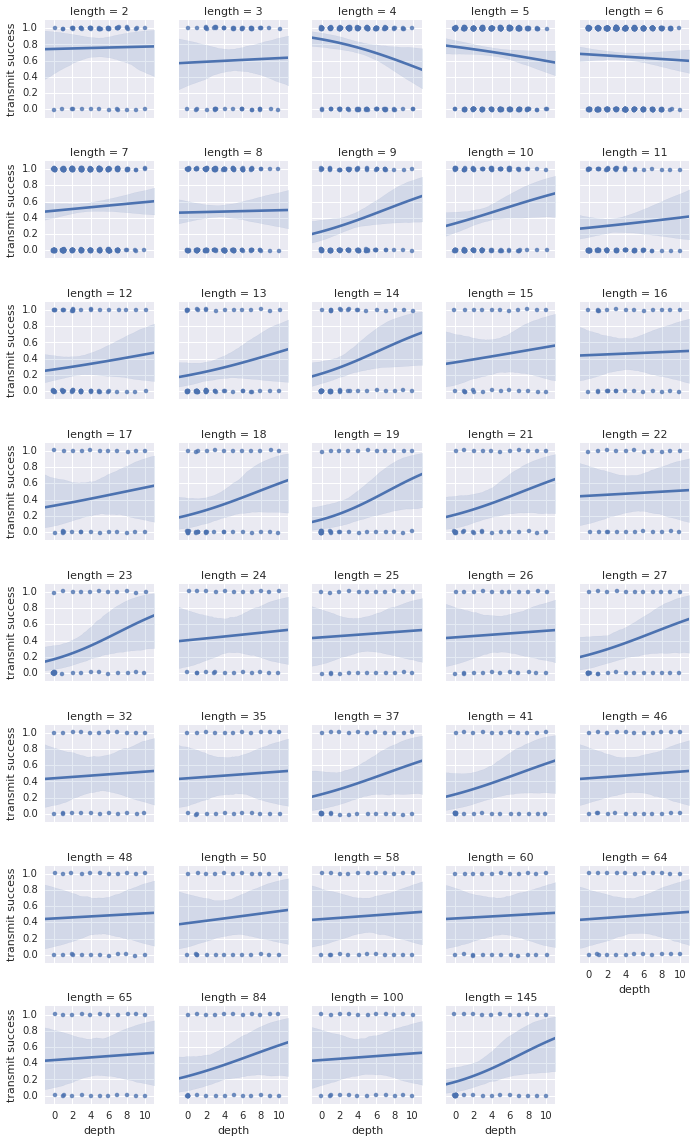

In [20]:
g = sb.lmplot(data=data23,
              x='depth', y='transmit success', logistic=True,
              col='length', col_wrap=5, size=2, col_order=ordered_lengths,
              x_jitter=.1, y_jitter=.01)
g.set(xlim=(-1, 11), ylim=(-0.1, 1.1))

Then restricting to trees where the root sentence is less than 15 content words

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

  warnings.warn(self.msg_depr % (key, alt_key))



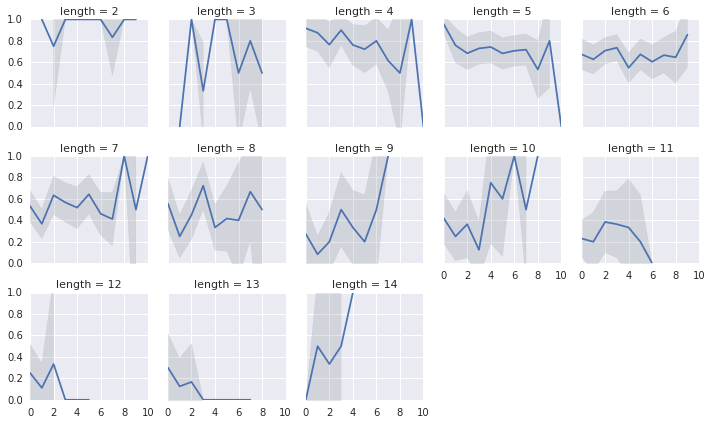

In [21]:
ordered_lengths_m15 = sorted(set(data_m15.length.values))
g = sb.FacetGrid(data=data_m15, col='length', col_wrap=5,
                 sharex=True, sharey=True, size=2,
                 col_order=ordered_lengths_m15)
g.map_dataframe(plot_transmissibility)

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

  warnings.warn(self.msg_depr % (key, alt_key))



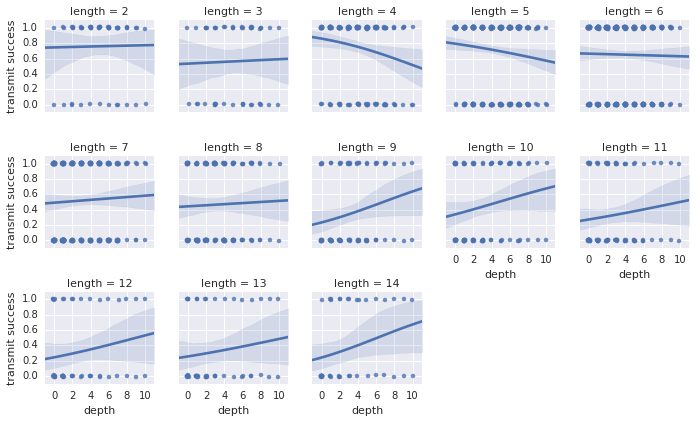

In [22]:
g = sb.lmplot(data=data23_m15,
              x='depth', y='transmit success', logistic=True,
              col='length', col_wrap=5, size=2, col_order=ordered_lengths_m15,
              x_jitter=.1, y_jitter=.01)
g.set(xlim=(-1, 11), ylim=(-0.1, 1.1))

### 2.4 Transmissibility ~ depth, per tree

**Note on logistic regressions**: same as the note at the beginning of 2.3, but we do it for each combination of tree_id and depth.

In [25]:
data24 = []
for tree_id, depth, success in product(set(data['tree id'].values),
                                       set(data.depth.values),
                                       [True, False]):
    data24.append({'tree id': tree_id,
                   'sentence id': -1,
                   'length': -1,
                   'root length': len(Tree.objects.get(id=tree_id).root.content_words),
                   'depth': depth,
                   'branch id': -1,
                   'transmit success': success})
data24 = data.append(DataFrame(data24))

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

  warnings.warn(self.msg_depr % (key, alt_key))



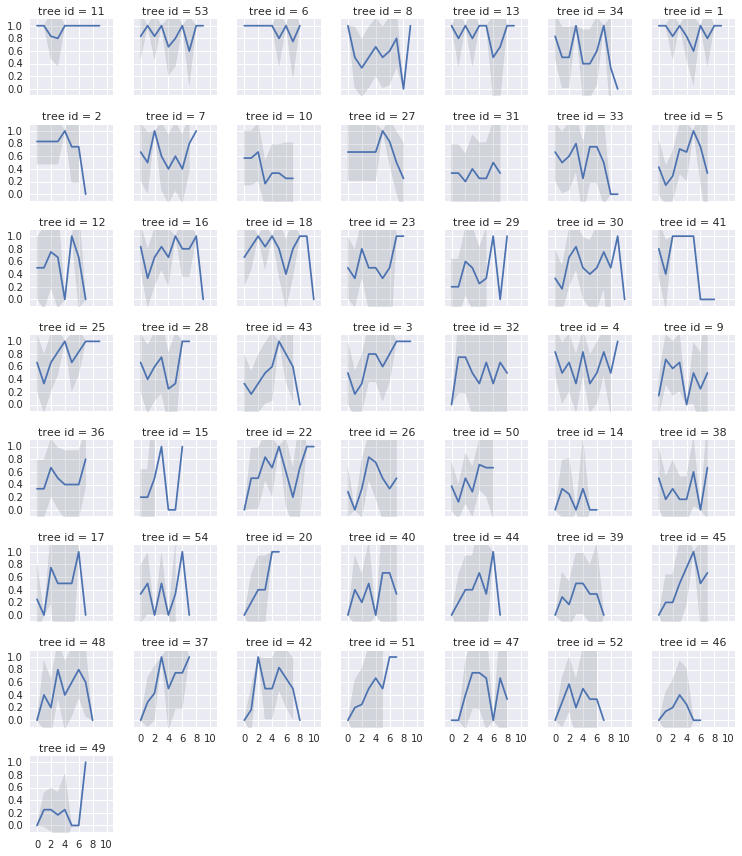

In [28]:
g = sb.FacetGrid(data=data, col='tree id', col_wrap=7,
                 sharex=True, sharey=True, size=1.5,
                 col_order=root_order['tree id'])
g.map_dataframe(plot_transmissibility)
g.set(xlim=(-1, 11), ylim=(-0.1, 1.1))

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

  warnings.warn(self.msg_depr % (key, alt_key))



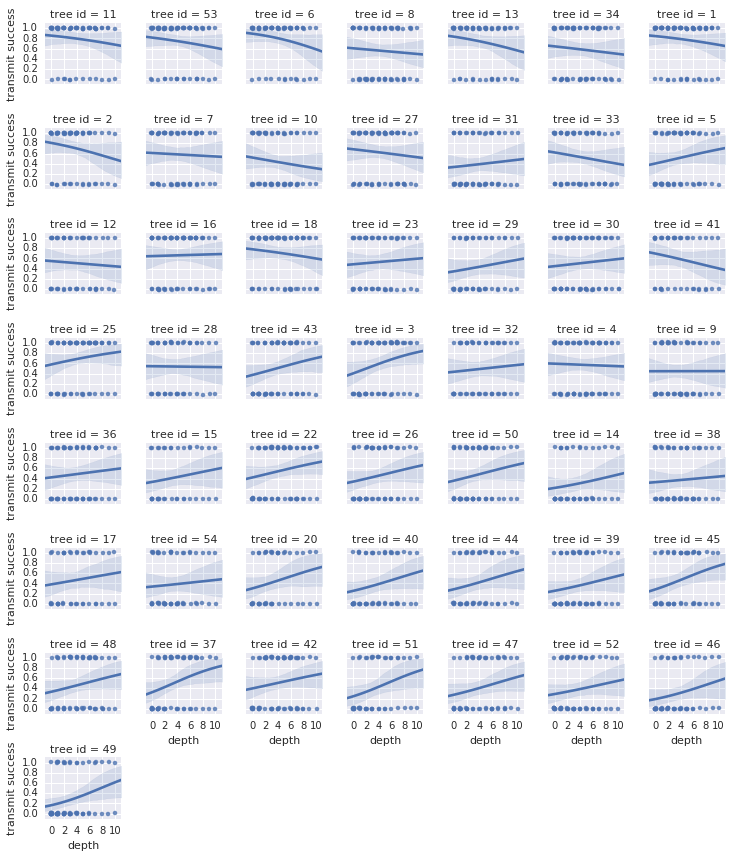

In [29]:
g = sb.lmplot(data=data24,
              x='depth', y='transmit success', logistic=True,
              col='tree id', col_wrap=7, size=1.5, col_order=root_order['tree id'],
              x_jitter=.1, y_jitter=.01)
g.set(xlim=(-1, 11), ylim=(-0.1, 1.1))